In [1]:
from fastai.vision.all import *
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

If the GPU is available use it for the computation otherwise use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Fashion MNIST

The Fashion MNIST dataset contains thousands of grayscale images of different types of clothes. There are ten distinct categories encoded into numbers 0 - 10:

0   T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

Download the dataset

In [3]:
train_set = datasets.FashionMNIST("./data", download=True, train=True, transform=transforms.Compose([transforms.ToTensor(), torch.flatten]))
test_set = datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor(), torch.flatten]))

We are going to feed the dataset into our network in batches of size 64 as the dataset is too big to be used all at once.

In [4]:
data_loader = DataLoaders.from_dsets(train_set, test_set, bs=128)

Let's check the mini batch you'll get from the train data loader:

In [5]:
x, y = next(iter(data_loader.train))
print(x.size(), y.size())
print(len(train_set))
print(len(test_set))
print(train_set[0][0].size())

torch.Size([128, 784]) torch.Size([128])
60000
10000
torch.Size([784])


In [6]:
clothes_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_loader.vocab = clothes_labels

Let's plot some images from our dataset

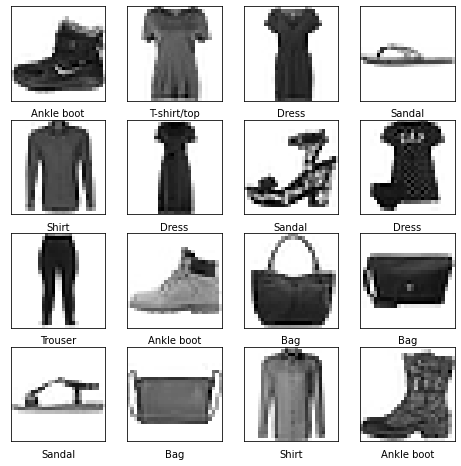

In [7]:
def plot_image(x, title = ""):
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(torch.reshape(x, (28,28)), cmap=plt.cm.binary)
  plt.xlabel(title)

plt.figure(figsize=(8,8))
for i in range(0, 160, 10):
  plt.subplot(4, 4, i // 10 + 1)
  plot_image(train_set[i][0], clothes_labels[train_set[i][1]])

# Dense NN

Let's try to apply dense neural network (we talked about it in the previous lesson) to our images.

All layers are Linear - the classic fully-connected neural network layers.

- The hidden layers will have 128 and 64 units and use the ReLU activation function.
- The output layer will have 10 units, corresponding to the 10 classes, and use softmax function.

The general convention for Pytorch network classes is that you create all your layers in the constructor, and then lay out their relationship in the `forward()` method.

In [8]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(image_size, 128) # TODO nn.Linear(n_input_neurons, n_output_neurons)
        self.fc2 = nn.Linear(128, 64) # TODO
        self.fc3 = nn.Linear(64, 10) # TODO

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [9]:
model = Net(image_size=28*28) # TODO
model.to(device)
model

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Training

In [10]:
# learning rate
lr = 5e-4
# loss function
loss_func = CrossEntropyLossFlat()

Rather then setting up the model optimization in Pytorch, we are going to use fastai's Learner object. (By default, it uses the Adam optimizer.)

In [11]:
learn = Learner(data_loader, model, loss_func=loss_func, metrics=accuracy)
learn.fit(n_epoch=5, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.690247,1.686081,0.785300,00:13
1,1.654416,1.661430,0.800900,00:13
2,1.632282,1.640803,0.824400,00:13
3,1.617936,1.626238,0.838500,00:13
4,1.614477,1.624585,0.840900,00:13


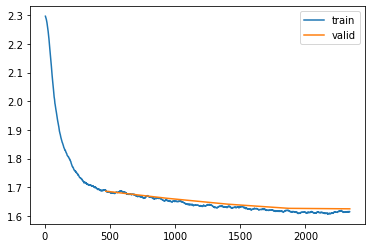

In [12]:
learn.recorder.plot_loss()

In [13]:
setattr(learn, "dl", learn.dls[1])
setattr(learn.dl, "vocab", [[], clothes_labels])
class_interp = ClassificationInterpretation.from_learner(learn, dl=learn.dl)

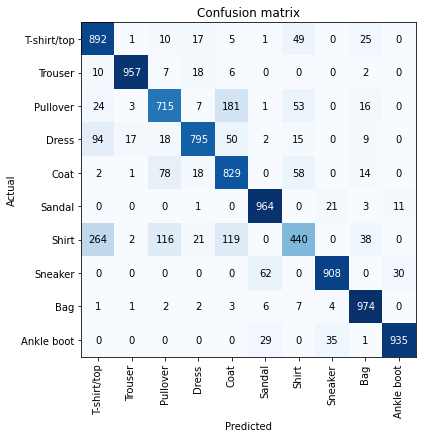

In [14]:
# For some unknown reason, fastai requires setting vocab attr manually for FashinMNIST, as well as using CrossEntropyLossFlat instead of CrossEntropy from nn. 
# Only under these conditions, ClassificationInterpretation works properly

setattr(learn.dl, "vocab", [[], clothes_labels])
class_interp = ClassificationInterpretation.from_learner(learn, dl=learn.dl)
class_interp.plot_confusion_matrix(figsize=(8, 6))

NN - Top 10 pictures where the model was least confident

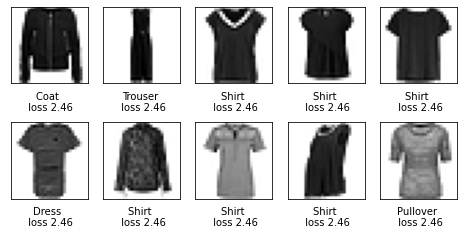

In [15]:
interp = Interpretation.from_learner(learn)
loss, idx = interp.top_losses(10, largest=True)

def plot_image(x, title = ""):
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(torch.reshape(x, (28,28)), cmap=plt.cm.binary)
  plt.xlabel(title)

plt.figure(figsize=(8,8))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plot_image(
    data_loader.valid.data[idx[i]], 
    clothes_labels[test_set[idx[i]][1]] + " \n loss {:.2f}".format(loss[i].item())
    )

NN - Top 10 pictures from the test set where the model was most confident but the prediction was wrong

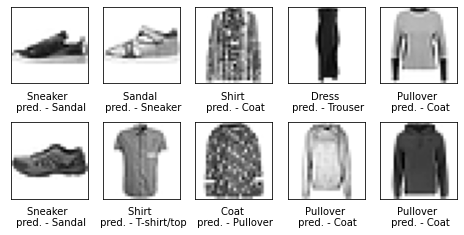

In [16]:
input, prob, targets, targets_pred, losses = learn.get_preds(1, with_decoded=True, with_loss=True, with_input=True)
fail_pred_losses = losses[targets != targets_pred]
sort_values, sort_idx = fail_pred_losses.sort()
top10 = sort_idx[:10]

def plot_image(x, title = ""):
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(torch.reshape(x, (28,28)), cmap=plt.cm.binary)
  plt.xlabel(title)

plt.figure(figsize=(8,8))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
for i in range(10):
  target_class = clothes_labels[targets[targets != targets_pred][sort_idx[i]]]
  pred_class = clothes_labels[targets_pred[targets != targets_pred][sort_idx[i].item()]]
  plt.subplot(2, 5, i + 1)
  plot_image(
    input[targets != targets_pred][sort_idx[i]], target_class + f" \n pred. - {pred_class}"
    )



---



# CNN

Let's try a different architecture, this time a Convolutional Neural Network

Load data in different format

In [17]:
train_set = datasets.FashionMNIST("./data", download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

data_loader = DataLoaders.from_dsets(train_set, test_set, bs=128)

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=24*24*64, out_features=128)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [19]:
model = CNN()
model.to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=36864, out_features=128, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Training

In [20]:
# learning rate
lr = 5e-4
# loss function
loss_func = CrossEntropyLossFlat()

Rather then setting up the model optimization in Pytorch, we are going to use fastai's Learner object. (By default, it uses the Adam optimizer.)

In [21]:
learn = Learner(data_loader, model, loss_func=loss_func, metrics=accuracy)
learn.fit(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.629621,1.622716,0.840300,00:26
1,1.597117,1.596382,0.866200,00:26
2,1.584822,1.585994,0.875800,00:25
3,1.578507,1.578546,0.883000,00:25
4,1.570161,1.580946,0.880500,00:27


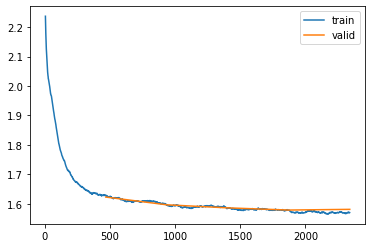

In [22]:
learn.recorder.plot_loss()

In [23]:
learn.dl

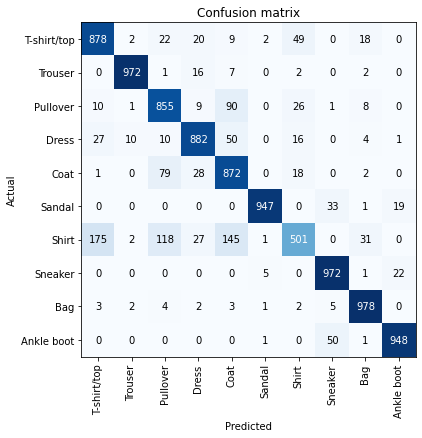

In [24]:
setattr(learn, "dl", learn.dls[1])
setattr(learn.dl, "vocab", [[], clothes_labels])
class_interp = ClassificationInterpretation.from_learner(learn, dl=learn.dl)
class_interp.plot_confusion_matrix(figsize=(8, 6))

CNN - Top 10 pictures where the model was least confident

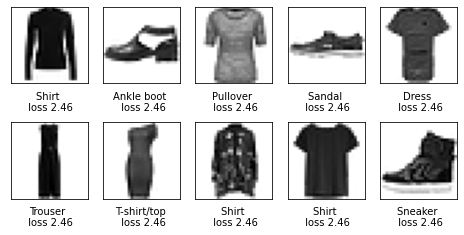

In [25]:
interp = Interpretation.from_learner(learn)
loss, idx = interp.top_losses(10, largest=True)

def plot_image(x, title = ""):
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(torch.reshape(x, (28,28)), cmap=plt.cm.binary)
  plt.xlabel(title)

plt.figure(figsize=(8,8))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plot_image(
    data_loader.valid.data[idx[i]], 
    clothes_labels[test_set[idx[i]][1]] + " \n loss {:.2f}".format(loss[i].item())
    )

CNN - Top 10 pictures from the test set where the model was most confident but the prediction was wrong

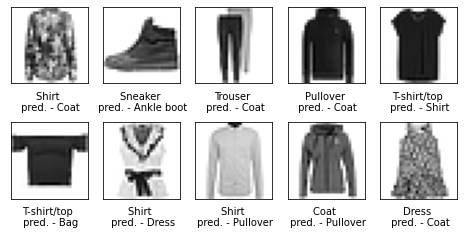

In [26]:
input, prob, targets, targets_pred, losses = learn.get_preds(1, with_decoded=True, with_loss=True, with_input=True)
fail_pred_losses = losses[targets != targets_pred]
sort_values, sort_idx = fail_pred_losses.sort()
top10 = sort_idx[:10]

def plot_image(x, title = ""):
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(torch.reshape(x, (28,28)), cmap=plt.cm.binary)
  plt.xlabel(title)

plt.figure(figsize=(8,8))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
for i in range(10):
  target_class = clothes_labels[targets[targets != targets_pred][sort_idx[i]]]
  pred_class = clothes_labels[targets_pred[targets != targets_pred][sort_idx[i].item()]]
  plt.subplot(2, 5, i + 1)
  plot_image(
    input[targets != targets_pred][sort_idx[i]], target_class + f" \n pred. - {pred_class}"
    )